In [1]:
# Load required libraries
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

In [2]:
# Reading in the dataset which is in .csv format, has column headings and has an index column
url = "https://raw.githubusercontent.com/lecriste/LDC/main/commodities.csv?token=GHSAT0AAAAAABQQRHJDKH6F724MSYM5OSI2YQBCXVA"
data = pd.read_csv(url, header = 0)
date_col = 'date'

#currency = data['currency'][0]
# Drop single-value feature
data.drop('currency', axis=1, inplace=True)

dataSettle = data[data.observation == 'Settle']
dataSettle = dataSettle.drop('observation', axis=1)
commodities = dataSettle.groupby(['instrument']).nunique()
comm = {commodities.index[0]: 'C', commodities.index[1]: 'S'}
maturities = dataSettle.groupby(['maturity']).nunique()
whole_year = maturities[date_col].max()

features = []
for c in comm:
    for m in set(dataSettle[dataSettle.instrument == c]['maturity']):
        features.append(comm[c]+"-"+m)
num_features_orig = len(features)
dates = sorted(set(dataSettle[date_col]))

In [3]:
#%%script false --no-raise-error
# This cell can take a couple of minutes, do not re-run unless needed \
# by uncommenting the line above
datesD = {}
for d in dates:
    datesD[d] = {}
    dataSettle_d = dataSettle[dataSettle.date == d]
    for c in set(dataSettle_d['instrument']):
        dataSettle_dc = dataSettle_d.query("instrument == @c")
        for m in set(dataSettle_dc['maturity']):
            datesD[d][comm[c]+"-"+m] = dataSettle_dc.query("maturity == @m")['value'].iloc[0]

In [4]:
# This function arranges the dataset to be used for surpervised learning by shifting the 
# features values by the number of index steps given in lag_steps

def sequential_to_supervised(data, lag_steps = 1, n_out = 1, dropnan = True, thresh = 0 \
                             , interpolate = True):
    # Get the number of features in dataset
    n_features = data.shape[1]
    cols = list()
    feature_names = list()
    
    for i in range(lag_steps, 0, -1):
        cols.append(data.shift(i)) # This will be the shifted dataset
        # Names of the shifted features
        feature_names += [(str(data.columns[j])) + '_t-%d' % (i) for j in range(n_features)]

    for i in range(0, n_out):
        cols.append(data.shift(-i))
        # Names of the shifted features
        if i == 0:
            feature_names += [(str(data.columns[j])) + '_t'  for j in range(n_features)]
        else:
            feature_names += [(str(data.columns[j])) + '_t+%d' % (i) for j in \
                              range(n_features)]

    agg = pd.concat(cols, axis=1) 
    agg.columns = feature_names

    if dropnan:
        agg.dropna(axis=1, thresh = agg.shape[0]/thresh if thresh else None, inplace=True)
    if interpolate:
        agg.interpolate(method='polynomial', order=2, limit_direction='both' \
                        , fill_value="extrapolate", inplace=True)

    return agg

In [5]:
dataset = pd.DataFrame.from_dict(datesD, orient='index')
dataset.index.name = date_col
dataset = dataset.set_index(pd.DatetimeIndex(dataset.index))

lag_steps = 1
thresh = 2 # Drop features missing more than 50% of observations
supervised_dataset = sequential_to_supervised(dataset, lag_steps, 1, True, thresh, True)
num_features = supervised_dataset.shape[1]
if (num_features != num_features_orig*2):
    print("The supervised_dataset has %d features (after shifting, duplicating \
    and cleaning)" % num_features)
    print("The original dataset had %d features" % num_features_orig)
    
#y_feature = "C-N2022" # The dataset column to be predicted
y_feature = "S-N2022" # The dataset column to be predicted
y_feature_t = y_feature+"_t"
if (y_feature_t not in supervised_dataset.columns):
    print("Error! The feature to predict ('%s') is not present in the supervised_dataset" % \
          y_feature)

# Move label column to the end of dataset
cols_at_end = [y_feature_t]
supervised_dataset = supervised_dataset[[c for c in supervised_dataset \
                                         if c not in cols_at_end] + \
                                        [c for c in cols_at_end if c in supervised_dataset]]

The supervised_dataset has 70 features (after shifting, duplicating     and cleaning)
The original dataset had 47 features


In [6]:
# Dropping the current timestep columns of features other than the one being predicted,
# which will be the label or y.
# Result: num_features/2 features with timestep -1 plus feature y
half_features = int(num_features / 2)
# Assuming the dropna dropped the same number of shifted and unshifted features
supervised_dataset.drop(supervised_dataset.columns[ \
                   (half_features*lag_steps) : (half_features*lag_steps + half_features -1) \
                                                  ], axis=1, inplace=True)
print(supervised_dataset.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling all values
supervised_dataset_scaled = scaler.fit_transform(supervised_dataset)

(231, 36)


In [7]:
train_fr = 0.8
split = int(supervised_dataset_scaled.shape[0] * train_fr) # Splitting for traning and testing
train = supervised_dataset_scaled[:split, :] # First train_fr rows := previous observations
test = supervised_dataset_scaled[split:, :] # Last 1-train_fr rows := successive observations

# The label column is separated out as "y"
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
# Reshaping done for LSTM as it needs 3D input
train_x_3D = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x_3D = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

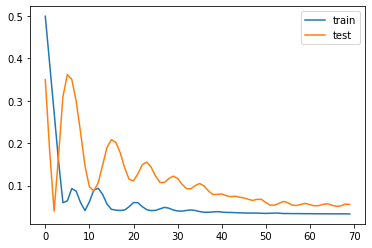

In [16]:
# Defining the LSTM model to be fit
model = Sequential()
model.add(LSTM(85, input_shape=(train_x_3D.shape[1], train_x_3D.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

if np.count_nonzero(np.isnan(train)):
    print("Warning! %d NaN values present in training dataset" % \
          np.count_nonzero(np.isnan(train)))
if np.count_nonzero(np.isnan(test)):
    print("Warning! %d NaN values present in test dataset" % \
          np.count_nonzero(np.isnan(test)))

# Fitting the model
history = model.fit(train_x_3D, train_y, epochs=70, batch_size=175, \
                    validation_data=(test_x_3D, test_y), verbose=0, shuffle=False)
# Plotting the training progression
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [17]:
# Using the trained model to predict the label values in test dataset
y_hat = model.predict(test_x_3D)

# Reshaping back into 2D for inversing the scaling
test_x = test_x_3D.reshape((test_x_3D.shape[0], test_x_3D.shape[2])) 

In [18]:
# Concatenating the predicted label column with Test data input features,
# needed for inversing the scaling
inv_y_hat = np.concatenate((test_x[:, 0:], y_hat), axis=1) 
inv_y_hat = scaler.inverse_transform(inv_y_hat) # Rescaling back
# Extracting the rescaled predicted label column
inv_y_hat = inv_y_hat[:, half_features*lag_steps]

test_y = test_y.reshape((len(test_y), 1))
# Re-join the test dataset for inversing the scaling
inv_y = np.concatenate((test_x[:, 0:], test_y), axis=1)
# Rescaling the actual label column values
inv_y = scaler.inverse_transform(inv_y)
# Extracting the rescaled actual label column
inv_y = inv_y[:, half_features*lag_steps]

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_hat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.611


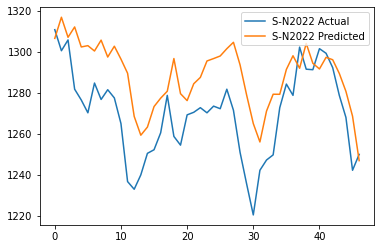

In [19]:
pyplot.plot(inv_y, label = y_feature+' Actual')
pyplot.plot(inv_y_hat, label = y_feature+' Predicted')
pyplot.legend()
pyplot.show()